In [1]:
import pandas as pd
import json

with open("option_columns.json","r") as f:
    option_columns = json.load(f)

#Find the dataset
# df = pd.read_csv("dataset_encoded_size.csv", dtype={k:"int8" for k in option_columns})
df = pd.read_csv("dataset_encoded_all_size.csv", dtype={k:"int8" for k in option_columns})
df.query("cid >= 30000", inplace=True)
df.fillna(-1, inplace=True)
df.query("vmlinux >= 0", inplace=True)



In [2]:
df[:10]

,X86_LOCAL_APIC,OPENVSWITCH,TEXTSEARCH_FSM,LOCKDEP_SUPPORT,GENERIC_CLOCKEVENTS_MIN_ADJUST,NETFILTER_XT_MATCH_TCPMSS,MPLS,NFC_HCI,STACKTRACE_SUPPORT,GENERIC_CMOS_UPDATE,...,XZ-bzImage,XZ-vmlinux,XZ,LZO-bzImage,LZO-vmlinux,LZO,LZ4-bzImage,LZ4-vmlinux,LZ4,cid
14758,1,0,0,1,1,0,1,0,1,1,...,5178320.0,7264848,4980068,8922064.0,11008072,8734199,9839568.0,11925896,9638560,30000
14759,1,0,0,1,1,0,0,0,1,1,...,2840016.0,4924448,2695928,4519376.0,6603288,4385061,4838864.0,6923096,4693085,30001
14760,1,0,0,1,1,0,0,0,1,1,...,8496592.0,10581024,8351248,12391888.0,14475800,12256864,13362640.0,15446872,13214970,30002
14761,1,0,0,1,1,0,0,0,1,1,...,6304720.0,8390008,6156724,8782800.0,10867576,8647251,9302992.0,11388080,9155423,30003
14762,1,0,0,1,1,0,0,1,1,1,...,12321744.0,14407032,12176312,17933264.0,20018040,17796721,19346384.0,21431472,19197696,30004
14763,1,0,1,1,1,0,0,0,1,1,...,5161936.0,7247224,5017068,8328144.0,10412920,8193340,8897488.0,10982576,8748171,30005
14764,1,0,0,1,1,0,1,0,1,1,...,6874064.0,8959352,6726164,9491408.0,11576184,9354542,10048464.0,12133552,9901074,30006
14765,1,0,0,1,1,0,0,1,1,1,...,22009616.0,24096560,21843248,33187600.0,35274032,33029312,35424016.0,37510768,35253064,30007
14766,1,0,0,1,1,0,0,0,1,1,...,3953616.0,6038904,3807028,6325200.0,8409976,6188651,6734800.0,8819888,6587832,30008
14767,1,0,0,1,1,0,1,0,1,1,...,6419408.0,8504352,6274964,9085904.0,11170328,8952807,9663440.0,11748184,9518916,30009


In [3]:
NO_ENCODED_VALUE = 0
YES_ENCODED_VALUE = 1
M_ENCODED_VALUE = 2

def nbyes(row):
    return sum(row == YES_ENCODED_VALUE)

def nbno(row):
    return sum(row == NO_ENCODED_VALUE)

def nbmodule(row):
    return sum(row == M_ENCODED_VALUE)

# df.query("kernel_size == 7304656")
# df.query("kernel_size == 7317008").apply(nbyes, axis=1) 
df.query("vmlinux == 7317008").apply(nbyes, axis=1) 

58621    240
dtype: int64

In [4]:
df['nbyes'] = df.apply(nbyes, axis=1)
df['nbno'] = df.apply(nbno, axis=1)
df['nbmodule'] = df.apply(nbmodule, axis=1)
df['nbyesmodule'] = df['nbyes'] + df['nbmodule']

In [5]:
df.sort_values(by='vmlinux', ascending=True)[['vmlinux', 'nbno', 'nbyes', 'nbmodule', 'nbyesmodule']]

,vmlinux,nbno,nbyes,nbmodule,nbyesmodule
109097,7304656,12237,241,0,241
58621,7317008,12238,240,0,240
107213,8716424,11068,741,669,1410
99232,10486184,11131,636,711,1347
99777,10504040,11351,721,406,1127
91160,10504144,10831,847,800,1647
109537,10511608,11226,724,528,1252
80771,10524528,11163,857,458,1315
66399,10572520,10731,816,931,1747
96643,10648928,10926,835,717,1552


In [6]:
size_methods = ["vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "GZIP", "BZIP2-bzImage", 
              "BZIP2-vmlinux", "BZIP2", "LZMA-bzImage", "LZMA-vmlinux", "LZMA", "XZ-bzImage", "XZ-vmlinux", "XZ", 
              "LZO-bzImage", "LZO-vmlinux", "LZO", "LZ4-bzImage", "LZ4-vmlinux", "LZ4"]

In [18]:
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["cid"]).drop(columns=size_methods), df["vmlinux"], test_size=0.1, random_state=42)  
gbreg = GradientBoostingRegressor()
gbreg.fit(X_train, y_train)
y_pred = gbreg.predict(X_test)
dfErrors = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred, "error":(y_pred - y_test).abs(), "% error":((y_pred - y_test)/y_test).abs()*100})
dfErrors["% error"].describe(), gbreg



(count    9248.000000
 mean       12.095440
 std        11.761506
 min         0.001641
 25%         4.251839
 50%         9.214462
 75%        16.219229
 max       176.990073
 Name: % error, dtype: float64,
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, n_iter_no_change=None, presort='auto',
              random_state=None, subsample=1.0, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False))

In [19]:
col = df.drop(columns=["cid"]).drop(columns=size_methods).columns
importanceGB = pd.Series(gbreg.feature_importances_, index=col.values)
importanceGB[importanceGB > 0].sort_values(ascending=False)



DEBUG_INFO                        0.399326
DEBUG_INFO_SPLIT                  0.137665
nbyes                             0.134361
DEBUG_INFO_REDUCED                0.110313
X86_NEED_RELOCS                   0.078811
UBSAN_SANITIZE_ALL                0.043656
RANDOMIZE_BASE                    0.036491
KASAN_OUTLINE                     0.012387
GCOV_PROFILE_ALL                  0.012304
UBSAN_ALIGNMENT                   0.006205
KASAN                             0.005257
XFS_DEBUG                         0.004060
BLK_MQ_PCI                        0.002547
DEBUG_INFO_DWARF4                 0.001276
SCSI_ISCSI_ATTRS                  0.001250
DRM_NOUVEAU                       0.001168
XFS_FS                            0.001000
MAXSMP                            0.000909
KCOV_INSTRUMENT_ALL               0.000790
XPS                               0.000749
X86_NUMACHIP                      0.000606
X86_VSMP                          0.000560
MDIO                              0.000533
DRM_AMDGPU 

array(['X86_LOCAL_APIC', 'OPENVSWITCH', 'TEXTSEARCH_FSM', ..., 'nbno',
       'nbmodule', 'nbyesmodule'], dtype=object)

In [20]:
importanceGB[importanceGB > 0].sort_values(ascending=False).to_csv("feature_importance_GB.csv", header=True)

In [36]:
ftIndiceImportanceGB = []
for ft_name in importanceGB[importanceGB > 0].sort_values(ascending=False).index:
    i = 0
    for vl in col.values:
        if (ft_name == vl):
            ftIndiceImportanceGB.append(i)
#            print(ft_name, "at", i)
            continue
        i = i + 1

ftIndiceImportanceGB


<Figure size 1440x1440 with 0 Axes>

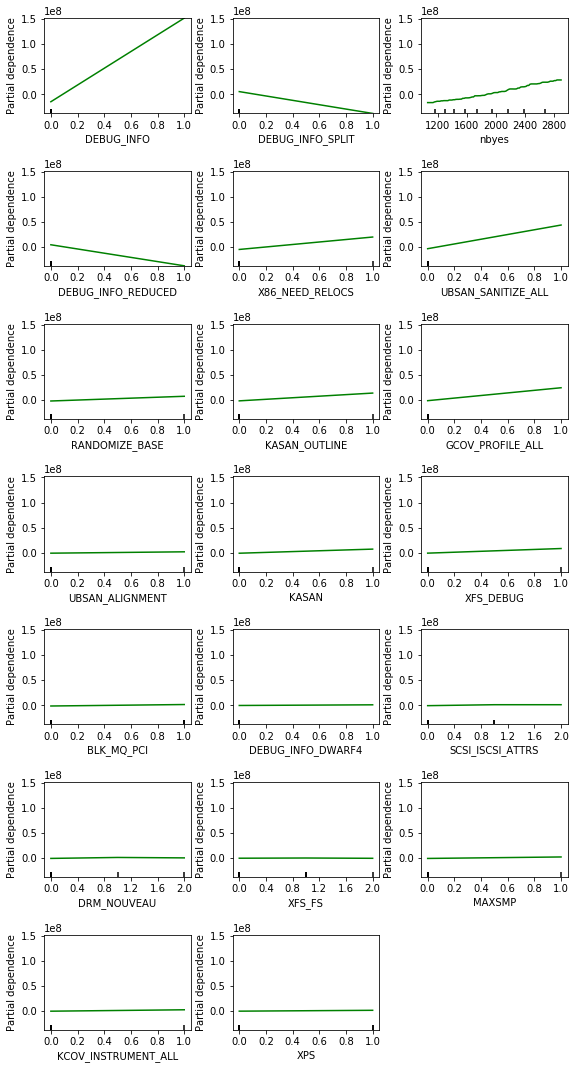

In [53]:
# len(importanceGB[importanceGB > 0])
import matplotlib.pyplot as plt
ftsDep = ftIndiceImportanceGB[:20] # importanceGB[importanceGB > 0].sort_values(ascending=False)[:10].values
plt.figure(figsize=(20, 20))
fig, ax = plot_partial_dependence(gbreg, X_test, ftsDep, feature_names=col.values, grid_resolution=100)
fig.set_figwidth(8)
fig.set_figheight(15)
fig.tight_layout()
plt.show()

In [54]:
from sklearn.model_selection import train_test_split
from sklearn import tree

def runML(hyperparams, test_size, with_tree=False):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["cid"]).drop(columns=size_methods), df["vmlinux"], test_size=test_size, random_state=hyperparams["random_state"])  
    reg = tree.DecisionTreeRegressor(**hyperparams)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    dfErrors = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred, "error":(y_pred - y_test).abs(), "% error":((y_pred - y_test)/y_test).abs()*100})
    if with_tree:
        return dfErrors["% error"].describe(), reg
    return dfErrors["% error"].describe()

In [58]:

hyperparams = {
    "criterion": "mse",
    "max_depth": 12,
    "min_samples_leaf": 5,
    "max_leaf_nodes": None,
    "random_state": 2
}
res, reg = runML(hyperparams, test_size=0.9, with_tree=True)

In [59]:
res

count    83224.000000
mean        15.882387
std         19.702202
min          0.000535
25%          5.225224
50%         11.106101
75%         19.954990
max        650.490205
Name: % error, dtype: float64

In [60]:
col = df.drop(columns=["cid"]).drop(columns=size_methods).columns
importanceSeries = pd.Series(reg.feature_importances_, index=col.values)
importanceSeries[importanceSeries > 0].sort_values(ascending=False)

DEBUG_INFO                    3.452112e-01
nbyes                         1.829045e-01
DEBUG_INFO_REDUCED            1.194663e-01
X86_NEED_RELOCS               1.146635e-01
DEBUG_INFO_SPLIT              9.049730e-02
UBSAN_SANITIZE_ALL            3.185399e-02
RANDOMIZE_BASE                1.753165e-02
GCOV_PROFILE_ALL              8.113397e-03
nbno                          7.542997e-03
KASAN                         7.443560e-03
DRM_AST                       6.919135e-03
KASAN_OUTLINE                 6.331010e-03
GREYBUS_POWER                 5.280098e-03
DRM_I915_GVT                  4.921367e-03
JOYSTICK_SPACEBALL            3.176610e-03
XFS_DEBUG                     2.942761e-03
UBSAN_ALIGNMENT               2.851865e-03
HID_ELO                       2.024970e-03
NLS_MAC_GREEK                 1.900275e-03
ISCSI_TARGET                  1.842800e-03
ACENIC                        1.760346e-03
DRM_NOUVEAU                   1.635278e-03
YENTA_ENE_TUNE                1.399204e-03
DEBUG_OBJEC

In [11]:
importanceSeries[importanceSeries > 0].sort_values(ascending=False).to_csv("feature_importance.csv", header=True)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn import ensemble

def runML_RF(hyperparams, with_tree=False):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["cid"]).drop(columns=size_methods), df["vmlinux"], test_size=0.1)  
    reg = ensemble.RandomForestRegressor(**hyperparams)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    dfErrors = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred, "error":(y_pred - y_test).abs(), "% error":((y_pred - y_test)/y_test).abs()*100})
    if with_tree:
        return dfErrors["% error"].describe(), reg
    return dfErrors["% error"].describe()


In [16]:
hyperparams = {
    "max_depth": 18,
    "n_estimators": 5,
    "n_jobs" : -1
}
resrf, regrf = runML_RF(hyperparams, with_tree=True)
resrf

count    9248.000000
mean        9.609661
std         9.115769
min         0.000925
25%         3.435585
50%         7.357657
75%        12.822383
max       139.467959
Name: % error, dtype: float64

In [17]:
importanceRF = pd.Series(regrf.feature_importances_, index=col.values)
importanceRF[importanceRF > 0].sort_values(ascending=False)

DEBUG_INFO                 3.282806e-01
nbyes                      1.868890e-01
DEBUG_INFO_REDUCED         1.126126e-01
DEBUG_INFO_SPLIT           8.395611e-02
RANDOMIZE_BASE             8.066183e-02
X86_NEED_RELOCS            6.407965e-02
UBSAN_SANITIZE_ALL         3.414532e-02
KASAN_OUTLINE              9.282186e-03
KASAN                      7.370490e-03
GCOV_PROFILE_ALL           7.084703e-03
UBSAN_ALIGNMENT            6.557924e-03
nbyesmodule                5.406531e-03
XFS_DEBUG                  3.091886e-03
nbno                       2.691681e-03
DRM_VMWGFX                 1.306744e-03
GPIO_ML_IOH                1.009128e-03
NFC_PN533_USB              9.770711e-04
XFS_FS                     9.622463e-04
CHELSIO_T1_1G              9.273372e-04
DRM_NOUVEAU                8.596195e-04
KCOV_INSTRUMENT_ALL        8.537169e-04
BLK_MQ_PCI                 7.939587e-04
SCSI_ISCSI_ATTRS           7.439807e-04
UBSAN_NULL                 6.206453e-04
MISDN_W6692                6.088424e-04


In [15]:
# df.to_pickle("all_size_withyes.pkl")